### Setup

In [1]:
import os
import sys
from pathlib import Path

# Add source directory to system path
source_dir = str(Path(os.getcwd()).parent / 'src')
sys.path.append(source_dir)

### MNIST Dataset Visualization

Label: 9


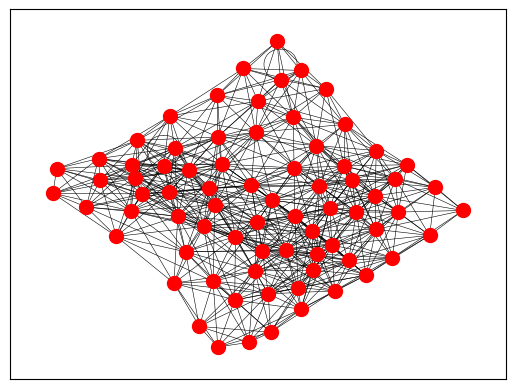

In [2]:
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.utils import to_networkx
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import os
import numpy as np

root = str(Path(os.getcwd()).parent / 'data' / 'mnist-superpixels')
dataset = MNISTSuperpixels(root=root)
sample = dataset[int(np.random.sample()*len(dataset))]
print("Label: {}".format(sample.y[0].cpu().numpy()))
G = to_networkx(sample, to_undirected=True)
nx.draw_networkx(G, with_labels=False, node_size=100, node_color="red", width=0.4)

### Model Initialization

In [3]:
from models import BasicGCN
model = BasicGCN(dataset.num_features, dataset.num_classes, embedding_size=256)
print("Number of Model Parameters: {}".format(sum(p.numel() for p in model.parameters())))

Number of Model Parameters: 137226


### Training

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader

dataset = dataset[: int(len(dataset) * 0.15)]   # comment out if using full dataset

# Training Parameters
num_epochs = 1000

train_test_split = 0.8
train_test_size = int(len(dataset) * train_test_split)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Hyperparameters
learning_rate = 0.002

# Loss Function and Optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data Loader
batch_size = 64
train_loader = DataLoader(dataset[: train_test_size], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset[train_test_size:], batch_size=batch_size, shuffle=True)

# Train
losses = []
epoch_losses = []

for epoch in range(num_epochs):
  for data in train_loader:
    data.to(device)
    optimizer.zero_grad()
    pred, aggr = model(data.x.float(), data.edge_index, data.batch)
    loss = loss_func(pred, data.y)
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  if epoch % 10 == 0:
    losses.append(np.mean(np.array(epoch_losses)))
    epoch_losses = []
    print("Epoch {} | Training Loss: {}".format(epoch, losses[-1]))

Epoch 0 | Training Loss: 2.300631864935951
Epoch 10 | Training Loss: 1.9935304384315964
Epoch 20 | Training Loss: 1.8817229989355644
Epoch 30 | Training Loss: 1.8465933060224078
Epoch 40 | Training Loss: 1.8094534930929673
Epoch 50 | Training Loss: 1.7760103787996073
Epoch 60 | Training Loss: 1.7426717746574267
Epoch 70 | Training Loss: 1.6916237024079381
Epoch 80 | Training Loss: 1.644404320484769
Epoch 90 | Training Loss: 1.6124866659662365
Epoch 100 | Training Loss: 1.5932525334105028
Epoch 110 | Training Loss: 1.5633207477299513
Epoch 120 | Training Loss: 1.54573647258556
Epoch 130 | Training Loss: 1.5222378895346043
Epoch 140 | Training Loss: 1.50279477908548
Epoch 150 | Training Loss: 1.487094773655444
Epoch 160 | Training Loss: 1.4766340268396698
Epoch 170 | Training Loss: 1.459456269456222
Epoch 180 | Training Loss: 1.4472443057372506
Epoch 190 | Training Loss: 1.4397136506781114
Epoch 200 | Training Loss: 1.4381178250355002
Epoch 210 | Training Loss: 1.4235262496281513
Epoch 2

In [21]:
# Save Weights
torch.save(model, str(Path(os.getcwd()).parent / 'model' / 'basic_gcn.model'))
# torch.save(model.state_dict(), str(Path(os.getcwd()).parent / 'model' / 'basic_gcn.weights'))

In [22]:
# Load Model (Example)
# weights = torch.load(str(Path(os.getcwd()).parent / 'model' / 'basic_gcn.weights'))
test_model = torch.load(str(Path(os.getcwd()).parent / 'model' / 'basic_gcn.model'))

In [27]:
# Testing
accuracies = []
with torch.no_grad():
  for batch in test_loader:
    batch.to(device)
    pred, embed = test_model(batch.x.float(), batch.edge_index, batch.batch)
    pred = torch.argmax(pred, dim=1)
    accuracy = np.sum(np.where(pred.cpu().numpy() - batch.y.cpu().numpy() == 0, 1, 0)) / len(batch)
    accuracies.append(accuracy)
print("Average Accuracy: {}".format(round(np.mean(accuracies), 2)))


Average Accuracy: 0.56
